# Debug notebook

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data as tud
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import sys
sys.path.insert(1, '../utils')
sys.path.insert(1, '../datasets')
sys.path.insert(1, '../utils_on_gpu')
import coco_utils as cu
import my_datasets as mdset
import eval_train as ev
import utils as U
import find_best_model as fbm   




## Parameters

In [2]:
#MODEL SAVE AND LOAD 
dataroot_voc = '/share/DEEPLEARNING/datasets/voc2012'
dataroot_sbd = '/share/DEEPLEARNING/datasets/sbd'
dataroot_coco = '/share/DEEPLEARNING/datasets/coco'
dataroot_coco2voc = '/users/k/karmimy/data/coco2voc'
load_dir = '/share/homes/karmimy/equiv/save_model/fully_supervised' #load a particular model 
fcn= True
pretrained=True

# GPU 
gpu = 1
# TRAIN PARAMETERS
batch_size = 2
gamma = 0.5
learning_rate = 10e-4
moment = 0.9
wd = 2e-4


# LOSS 

criterion_supervised = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.
Loss = 'KL' # Loss = 'KL' or 'CE' or None for L1,MSE…
criterion_unsupervised = U.get_criterion(Loss)


# DATASET AND DATA AUG 
rotate = False # random rotation during training
scale = True
split = True # split the supervised dataset
ratio = 0.3 # percent of data of VOC + SBD we use for supervised dataset
#scale_factor = (0.2,0.8)
#size_img = (420,420) 
#size_crop = (380,380)

## DATASETS

In [3]:
train_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='train', \
        download=True,rotate=rotate,scale=scale)#,size_img=size_img,size_crop=size_crop)
val_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=True)
train_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='train_noval',mode='segmentation',\
        rotate=rotate,scale=scale)#,size_img=size_img,size_crop=size_crop)

Using downloaded and verified file: /share/DEEPLEARNING/datasets/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /share/DEEPLEARNING/datasets/voc2012/VOCtrainval_11-May-2012.tar


In [4]:


dataloader_train_VOC = torch.utils.data.DataLoader(train_dataset_VOC, batch_size=batch_size,\
                                                       shuffle=True,drop_last=True)
#dataloader_train_sup = torch.utils.data.DataLoader(train_dataset_sup, batch_size=batch_size,\
#                                                       shuffle=True,drop_last=True)
#dataloader_train_equiv = torch.utils.data.DataLoader(train_dataset_unsup,batch_size=batch_size,\
#                                                     shuffle=True,drop_last=True)

dataloader_val = torch.utils.data.DataLoader(val_dataset_VOC, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:1



## FCN Pytorch

In [5]:
def load_model(file=None,fcn=False,pretrained=False):
    if file is None:
        if fcn is False:
            model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=pretrained)
        else:
            model = torchvision.models.segmentation.fcn_resnet101(pretrained=pretrained)
    else:
        model = torch.load(os.path.join(SAVE_DIR,file))
    return model

In [6]:
model = load_model(file=None,fcn=False,pretrained=True)
model.to(device)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /users/k/karmimy/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


, bias=False)
        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (3): Bottleneck(
        (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (layer3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Test Rotation


In [7]:
i,m=train_dataset_VOC.__getitem__(0)
ip = i.clone().transpose_(0,2).transpose_(0,1)


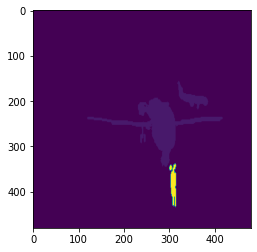

In [8]:
plt.imshow(m)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


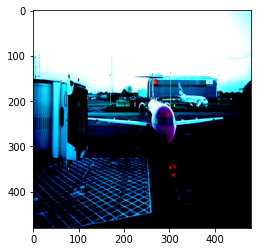

In [9]:
plt.imshow(ip)

In [11]:
model.eval()
out = model(i.unsqueeze(0).to(device))


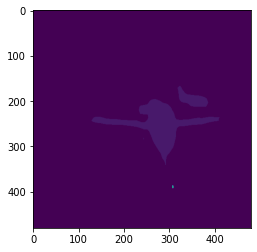

In [12]:
try:
    out = out['out'].detach().cpu()
except:
    pass
plt.imshow(out.argmax(dim=1).detach().cpu()[0])

In [13]:
torch.unique(out.argmax(dim=1)[0])

tensor([ 0,  1, 15])

In [18]:
i,m=train_dataset_VOC.__getitem__(0)
i = TF.rotate(i.unsqueeze(0),angle=30)
print(i.size())

torch.Size([1, 3, 480, 480])


In [21]:
ip = i.clone().transpose_(1,3).transpose_(1,2)
ip.size()

torch.Size([1, 480, 480, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


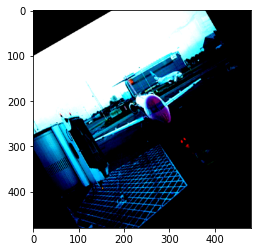

In [22]:
plt.imshow(ip[0])

In [23]:
out

tensor([[[[ 9.7257,  9.7257,  9.7257,  ..., 10.6217, 10.6217, 10.6217],
          [ 9.7257,  9.7257,  9.7257,  ..., 10.6217, 10.6217, 10.6217],
          [ 9.7257,  9.7257,  9.7257,  ..., 10.6217, 10.6217, 10.6217],
          ...,
          [ 9.3337,  9.3337,  9.3337,  ...,  7.9991,  7.9991,  7.9991],
          [ 9.3337,  9.3337,  9.3337,  ...,  7.9991,  7.9991,  7.9991],
          [ 9.3337,  9.3337,  9.3337,  ...,  7.9991,  7.9991,  7.9991]],

         [[ 0.6281,  0.6281,  0.6281,  ..., -0.3351, -0.3351, -0.3351],
          [ 0.6281,  0.6281,  0.6281,  ..., -0.3351, -0.3351, -0.3351],
          [ 0.6281,  0.6281,  0.6281,  ..., -0.3351, -0.3351, -0.3351],
          ...,
          [ 0.8538,  0.8538,  0.8538,  ...,  1.3038,  1.3038,  1.3038],
          [ 0.8538,  0.8538,  0.8538,  ...,  1.3038,  1.3038,  1.3038],
          [ 0.8538,  0.8538,  0.8538,  ...,  1.3038,  1.3038,  1.3038]],

         [[-1.9463, -1.9463, -1.9463,  ..., -2.0537, -2.0537, -2.0537],
          [-1.9463, -1.9463, -

In [24]:
out.size()

torch.Size([1, 21, 480, 480])

In [26]:
out = TF.rotate(out,angle=30)

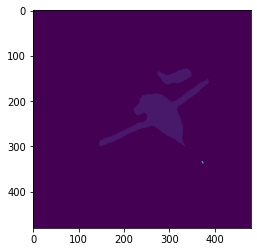

In [27]:
plt.imshow(out.argmax(dim=1).detach().cpu()[0])